In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [2]:
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size*percentage/100)]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        for n in range(n_bus):
            x_raw_1.append(list([dataset[i, 4*n+1], dataset[i, 4*n+2]]))
            y_raw_1.extend(dataset[i, 4*n+3:4*n+5])

        x_raw.append(list(x_raw_1))
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []

    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    x_mean = torch.mean(x,0)
    y_mean = torch.mean(y,0)
    x_std = torch.std(x,0)
    y_std = torch.std(y,0)
    x_norm = (x-x_mean)/x_std
    y_norm = (y-y_mean)/y_std
    x_norm = torch.where(torch.isnan(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isnan(y_norm), torch.zeros_like(y_norm), y_norm)
    x_norm = torch.where(torch.isinf(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isinf(y_norm), torch.zeros_like(y_norm), y_norm)
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    y = y_norm*y_std+y_mean
    return y

def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [3]:
dataset1 = pd.read_excel('dataset\Grid_14 bus_1.xlsx').values
dataset2 = pd.read_excel('dataset\Grid_14 bus_2.xlsx').values

In [4]:
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

#normalized data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

In [5]:
x_train, y_train = x_norm_train, y_norm_train
x_val, y_val = x_norm_val, y_norm_val
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 5, 8, 5, 9, 1, 10, 10, 11, 11, 12, 11, 13],
                           [1, 0, 2, 1, 3, 1, 4, 2, 5, 3, 6, 4, 7, 4, 8, 5, 9, 5, 10, 1, 11, 10, 12, 11, 13, 11]], dtype=torch.long)

data_train_list, data_val_list = [], []
for i,_ in enumerate(x_train):
    data_train_list.append(Data(x=x_train[i], y=y_train[i], edge_index=edge_index))
for i,_ in enumerate(x_val):
    data_val_list.append(Data(x=x_val[i], y=y_val[i], edge_index=edge_index))

train_loader = DataLoader(data_train_list, batch_size=1)
val_loader = DataLoader(data_val_list, batch_size=1)

c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
class My_GNN_GNN_NN(torch.nn.Module):
    def __init__(self, node_size=None, feat_in=None, feat_size1=None, feat_size2=None, hidden_size1=None, output_size=None):
        super(My_GNN_GNN_NN, self).__init__()
        self.feat_in = feat_in if feat_in is not None else 2
        self.feat_size1 = feat_in if feat_in is not None else 5
        self.feat_size2 = feat_in if feat_in is not None else 4
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 38
        self.output_size = output_size if output_size is not None else 18
        
        self.conv1 = GCNConv(feat_in, feat_size1)
        self.conv2 = GCNConv(feat_size1, feat_size2)
        self.lin1 = Linear(node_size*feat_size2, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)

        x = x.flatten(start_dim = 0)
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [7]:

feat_in = 2
feat_size1 = 8
feat_size2 = 4
hidden_size1 = 30
output_size = n_bus*2
lr = 0.0001

model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

conv1.bias
torch.Size([8])
conv1.lin.weight
torch.Size([8, 2])
conv2.bias
torch.Size([4])
conv2.lin.weight
torch.Size([4, 8])
lin1.weight
torch.Size([30, 56])
lin1.bias
torch.Size([30])
lin2.weight
torch.Size([28, 30])
lin2.bias
torch.Size([28])


2638

In [8]:
%%time

feat_in = 2
feat_size1 = 8
feat_size2 = 4
hidden_size1 = 30
output_size = n_bus*2
lr = 0.0001

model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=2000
lossMin = 1e10

for epoch in range(2001):

    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_train_prediction = model(batch)
        loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss=0
    for batch in val_loader:
        y_val_prediction = model(batch)
        loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        val_loss += loss.item() * batch.num_graphs
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    if (train_loss <= 0):
        print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
        break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 0.1513637    val loss: 0.0251612
epoch: 10    train loss: 0.0045677    val loss: 0.0043714
epoch: 20    train loss: 0.0031053    val loss: 0.0031458
epoch: 30    train loss: 0.0025086    val loss: 0.0026121
epoch: 40    train loss: 0.0021309    val loss: 0.0022720
epoch: 50    train loss: 0.0018333    val loss: 0.0019997
epoch: 60    train loss: 0.0015611    val loss: 0.0017368
epoch: 70    train loss: 0.0012956    val loss: 0.0014603
epoch: 80    train loss: 0.0010602    val loss: 0.0012045
epoch: 90    train loss: 0.0008911    val loss: 0.0010339
epoch: 100    train loss: 0.0007791    val loss: 0.0009361
epoch: 110    train loss: 0.0006945    val loss: 0.0008672
epoch: 120    train loss: 0.0006235    val loss: 0.0008106
epoch: 130    train loss: 0.0005621    val loss: 0.0007625
epoch: 140    train loss: 0.0005091    val loss: 0.0007221
epoch: 150    train loss: 0.0004634    val loss: 0.0006889
epoch: 160    train loss: 0.0004242    val loss: 0.0006622
epoch: 1

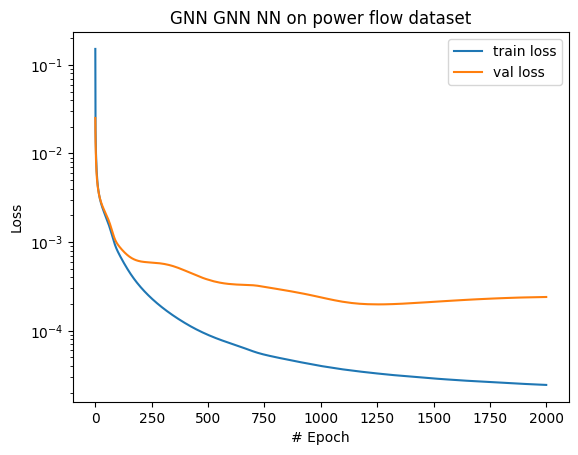

last epoch: 2000, train loss: 0.0000244, val loss: 0.0002401
best epoch: 1256, train loss: 0.0000328, val loss: 0.0001981


In [9]:
plt.title('GNN GNN NN on power flow dataset')
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [10]:
model.eval()

y_train_prediction_1 = model(train_loader.dataset[0])
train_loss_1 = MSE(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_train[0], y_val_mean, y_val_std))
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = model(val_loader.dataset[0])
val_loss_1 = MSE(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_val[0], y_val_mean, y_val_std))
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))

val_loss=0
for batch in val_loader:
    pred = model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    val_loss += loss.item() * batch.num_graphs
val_loss /= len(val_loader.dataset)
print('Val loss (MSE): {:.7f}'.format(val_loss))

[1 datapoint] Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
[1 datapoint] Train output prediction: 
[  10.32431 -154.21046    9.88232 -156.10869    9.7536  -156.7061
    9.72545 -156.82799    9.65984 -157.15486    9.60769 -157.38443
    9.61869 -157.35979    9.62865 -157.30222    9.58318 -157.49615
    9.56022 -157.61624    9.77316 -156.60657    9.68291 -157.03154
    9.65886 -157.14206    9.66447 -157.11574]
[1 datapoint] Train loss (MSE): 0.0000427
Train loss (MSE): 0.0000155
[1 datapoint] Val output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869 

In [11]:
best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

y_train_prediction_1 = best_model(train_loader.dataset[0])
train_loss_1 = MSE(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_train[0], y_val_mean, y_val_std))
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = best_model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = best_model(val_loader.dataset[0])
val_loss_1 = MSE(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_val[0], y_val_mean, y_val_std))
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))

val_loss=0
for batch in val_loader:
    pred = best_model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    val_loss += loss.item() * batch.num_graphs
val_loss /= len(val_loader.dataset)
print('Val loss (MSE): {:.7f}'.format(val_loss))

[1 datapoint] Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
[1 datapoint] Train output prediction: 
[  10.32463 -154.21135    9.88305 -156.10765    9.75452 -156.70573
    9.72618 -156.82776    9.66056 -157.15498    9.60817 -157.3849
    9.6192  -157.36005    9.62979 -157.3011     9.58401 -157.49521
    9.5609  -157.61502    9.77362 -156.60683    9.68328 -157.0316
    9.65981 -157.14005    9.66476 -157.11508]
[1 datapoint] Train loss (MSE): 0.0000482


C:\Users\panka\AppData\Local\Temp\ipykernel_1404\1251678827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model

Train loss (MSE): 0.0000184
[1 datapoint] Val output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
[1 datapoint] Val output prediction: 
[  10.30226 -154.7856     9.84348 -156.74196    9.68723 -157.4568
    9.6848  -157.48302    9.5762  -157.97821    9.56555 -158.05728
    9.5438  -158.13081    9.53473 -158.17545    9.51689 -158.29759
    9.53328 -158.2149     9.72641 -157.27466    9.62942 -157.73009
    9.59925 -157.87209    9.59427 -157.8965 ]
[1 datapoint] Val loss (MSE): 0.0000193
Val loss (MSE): 0.0001981


In [12]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    x_test, y_test = x_norm_test, y_norm_test
    
    data_test_list = []
    for j,_ in enumerate(x_test):
        data_test_list.append(Data(x=x_test[j], y=y_test[j], edge_index=edge_index))

    test_loader = DataLoader(data_test_list, batch_size=1)
    
    print('dataset {:d}'.format(i+1))
    
    test_loss = 0
    for batch in test_loader:
        y_test_prediction = best_model(batch)
        loss = MSE(denormalize_output(y_test_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        test_loss += loss.item() * batch.num_graphs
    test_loss /= len(test_loader.dataset)
    
    if i == 0:
        print('Train loss (MSE): {:.7f}'.format(test_loss))
    elif i == 1:
        print('Val loss (MSE): {:.7f}'.format(test_loss))
    else:
        print('Test loss (MSE): {:.7f}'.format(test_loss))
        test_loss_list.append(test_loss)
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [MSE] GNN GNN NN test loss.xlsx")
print("\ntest loss file saved!\n")

<timed exec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarni

dataset 1
Train loss (MSE): 0.0000184


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 2
Val loss (MSE): 0.0001981


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 3
Test loss (MSE): 0.0000732


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 4
Test loss (MSE): 0.0001569


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 5
Test loss (MSE): 0.0001407


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 6
Test loss (MSE): 0.0000434


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 7
Test loss (MSE): 0.0001165


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 8
Test loss (MSE): 0.0001626


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 9
Test loss (MSE): 0.0000978


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 10
Test loss (MSE): 0.0001341


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 11
Test loss (MSE): 0.0001028


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 12
Test loss (MSE): 0.0002683


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 13
Test loss (MSE): 0.0000520


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 14
Test loss (MSE): 0.0000929


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 15
Test loss (MSE): 0.0000815


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 16
Test loss (MSE): 0.0000509


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 17
Test loss (MSE): 0.0000613


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 18
Test loss (MSE): 0.0001289


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 19
Test loss (MSE): 0.0001046


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 20
Test loss (MSE): 0.0002369


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 21
Test loss (MSE): 0.0001337


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 22
Test loss (MSE): 0.0001051


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 23
Test loss (MSE): 0.0000894


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 24
Test loss (MSE): 0.0001066


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 25
Test loss (MSE): 0.0000976


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 26
Test loss (MSE): 0.0000878


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 27
Test loss (MSE): 0.0001667


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 28
Test loss (MSE): 0.0001937


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 29
Test loss (MSE): 0.0000880


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 30
Test loss (MSE): 0.0001737


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 31
Test loss (MSE): 0.0001323


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 32
Test loss (MSE): 0.0000615


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 33
Test loss (MSE): 0.0000668


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 34
Test loss (MSE): 0.0000761


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 35
Test loss (MSE): 0.0000596


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 36
Test loss (MSE): 0.0001000


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 37
Test loss (MSE): 0.0000680


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 38
Test loss (MSE): 0.0001038


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 39
Test loss (MSE): 0.0001090


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 40
Test loss (MSE): 0.0001692


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 41
Test loss (MSE): 0.0000602


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 42
Test loss (MSE): 0.0001742


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 43
Test loss (MSE): 0.0000860


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 44
Test loss (MSE): 0.0001276


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 45
Test loss (MSE): 0.0001118


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 46
Test loss (MSE): 0.0001132


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 47
Test loss (MSE): 0.0001171


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 48
Test loss (MSE): 0.0001081


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 49
Test loss (MSE): 0.0000821


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 50
Test loss (MSE): 0.0000860


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 51
Test loss (MSE): 0.0001103


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 52
Test loss (MSE): 0.0002053


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 53
Test loss (MSE): 0.0000531


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 54
Test loss (MSE): 0.0001065


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 55
Test loss (MSE): 0.0001616


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 56
Test loss (MSE): 0.0001490


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 57
Test loss (MSE): 0.0000997


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 58
Test loss (MSE): 0.0000757


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 59
Test loss (MSE): 0.0001482


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 60
Test loss (MSE): 0.0003300


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 61
Test loss (MSE): 0.0000898


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 62
Test loss (MSE): 0.0001593


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 63
Test loss (MSE): 0.0000626


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 64
Test loss (MSE): 0.0001480


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 65
Test loss (MSE): 0.0000916


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 66
Test loss (MSE): 0.0002166


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 67
Test loss (MSE): 0.0000835


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 68
Test loss (MSE): 0.0001649


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 69
Test loss (MSE): 0.0000808


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 70
Test loss (MSE): 0.0001792


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 71
Test loss (MSE): 0.0001522


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 72
Test loss (MSE): 0.0000972


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 73
Test loss (MSE): 0.0002833


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 74
Test loss (MSE): 0.0001096


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 75
Test loss (MSE): 0.0001546


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 76
Test loss (MSE): 0.0000971


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 77
Test loss (MSE): 0.0000861


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 78
Test loss (MSE): 0.0003070


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 79
Test loss (MSE): 0.0000822


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 80
Test loss (MSE): 0.0000565


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 81
Test loss (MSE): 0.0001744


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 82
Test loss (MSE): 0.0001557


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 83
Test loss (MSE): 0.0001343


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 84
Test loss (MSE): 0.0000686


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 85
Test loss (MSE): 0.0001282


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 86
Test loss (MSE): 0.0000695


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 87
Test loss (MSE): 0.0000970


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 88
Test loss (MSE): 0.0001259


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 89
Test loss (MSE): 0.0003668


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 90
Test loss (MSE): 0.0000975


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 91
Test loss (MSE): 0.0003089


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 92
Test loss (MSE): 0.0001690


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 93
Test loss (MSE): 0.0001865


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 94
Test loss (MSE): 0.0000474


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 95
Test loss (MSE): 0.0001806


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 96
Test loss (MSE): 0.0001095


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 97
Test loss (MSE): 0.0001370


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 98
Test loss (MSE): 0.0000585


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 99
Test loss (MSE): 0.0001236


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 100
Test loss (MSE): 0.0000730


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 101
Test loss (MSE): 0.0001657


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 102
Test loss (MSE): 0.0000904

test loss file saved!

CPU times: total: 4min 12s
Wall time: 6min


In [13]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    x_test, y_test = x_norm_test, y_norm_test
    
    data_test_list = []
    for j,_ in enumerate(x_test):
        data_test_list.append(Data(x=x_test[j], y=y_test[j], edge_index=edge_index))

    test_loader = DataLoader(data_test_list, batch_size=1)
    
    print('dataset {:d}'.format(i+1))
    
    test_loss = 0
    yhat = torch.empty(0, n_bus*2)
    for batch in test_loader:
        y_test_prediction = best_model(batch)
        yhat = torch.cat((yhat, y_test_prediction.reshape(1, n_bus*2)))
    
    yhat = denormalize_output(yhat, y_val_mean, y_val_std)
    y = y_raw_test
    test_loss_NRMSE = NRMSE(yhat, y)
    
    if i == 0:
        print('Train loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    elif i == 1:
        print('Val loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    else:
        print('Test loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
        test_loss_list.append(test_loss_NRMSE.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [NRMSE] GNN GNN NN test loss.xlsx")
print("\ntest loss file saved!\n")

<timed exec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarni

dataset 1
Train loss (NRMSE): 0.0251995


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 2
Val loss (NRMSE): 0.0255615


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 3
Test loss (NRMSE): 0.0250296


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 4
Test loss (NRMSE): 0.0303551


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 5
Test loss (NRMSE): 0.0298129


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 6
Test loss (NRMSE): 0.0254737


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 7
Test loss (NRMSE): 0.0524313


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 8
Test loss (NRMSE): 0.0703657


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 9
Test loss (NRMSE): 0.0311080


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 10
Test loss (NRMSE): 0.0586970


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 11
Test loss (NRMSE): 0.0462512


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 12
Test loss (NRMSE): 0.0389273


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 13
Test loss (NRMSE): 0.0256449


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 14
Test loss (NRMSE): 0.0287831


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 15
Test loss (NRMSE): 0.0282159


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 16
Test loss (NRMSE): 0.0325428


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 17
Test loss (NRMSE): 0.0343759


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 18
Test loss (NRMSE): 0.0407624


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 19
Test loss (NRMSE): 0.0300354


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 20
Test loss (NRMSE): 0.0322820


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 21
Test loss (NRMSE): 0.0414454


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 22
Test loss (NRMSE): 0.0368230


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 23
Test loss (NRMSE): 0.0351266


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 24
Test loss (NRMSE): 0.0592972


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 25
Test loss (NRMSE): 0.0412990


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 26
Test loss (NRMSE): 0.0302301


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 27
Test loss (NRMSE): 0.0389708


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 28
Test loss (NRMSE): 0.0315597


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 29
Test loss (NRMSE): 0.0277487


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 30
Test loss (NRMSE): 0.0570432


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 31
Test loss (NRMSE): 0.0479742


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 32
Test loss (NRMSE): 0.0243555


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 33
Test loss (NRMSE): 0.0385595


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 34
Test loss (NRMSE): 0.0284074


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 35
Test loss (NRMSE): 0.0628892


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 36
Test loss (NRMSE): 0.0335338


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 37
Test loss (NRMSE): 0.0256238


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 38
Test loss (NRMSE): 0.0462545


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 39
Test loss (NRMSE): 0.0417485


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 40
Test loss (NRMSE): 0.0534493


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 41
Test loss (NRMSE): 0.0303671


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 42
Test loss (NRMSE): 0.0354544


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 43
Test loss (NRMSE): 0.0306378


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 44
Test loss (NRMSE): 0.0314548


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 45
Test loss (NRMSE): 0.0304516


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 46
Test loss (NRMSE): 0.0322875


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 47
Test loss (NRMSE): 0.0301911


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 48
Test loss (NRMSE): 0.0326964


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 49
Test loss (NRMSE): 0.0433778


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 50
Test loss (NRMSE): 0.0326722


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 51
Test loss (NRMSE): 0.0301165


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 52
Test loss (NRMSE): 0.0352088


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 53
Test loss (NRMSE): 0.0362533


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 54
Test loss (NRMSE): 0.0294692


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 55
Test loss (NRMSE): 0.0316955


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 56
Test loss (NRMSE): 0.0388420


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 57
Test loss (NRMSE): 0.0310271


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 58
Test loss (NRMSE): 0.0361105


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 59
Test loss (NRMSE): 0.0316468


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 60
Test loss (NRMSE): 0.0290846


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 61
Test loss (NRMSE): 0.0313952


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 62
Test loss (NRMSE): 0.0336075


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 63
Test loss (NRMSE): 0.0425571


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 64
Test loss (NRMSE): 0.0299341


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 65
Test loss (NRMSE): 0.0264276


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 66
Test loss (NRMSE): 0.0314004


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 67
Test loss (NRMSE): 0.0298287


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 68
Test loss (NRMSE): 0.0331282


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 69
Test loss (NRMSE): 0.0355069


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 70
Test loss (NRMSE): 0.0573639


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 71
Test loss (NRMSE): 0.0321663


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 72
Test loss (NRMSE): 0.0355922


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 73
Test loss (NRMSE): 0.0635837


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 74
Test loss (NRMSE): 0.0304960


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 75
Test loss (NRMSE): 0.0416246


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 76
Test loss (NRMSE): 0.0259682


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 77
Test loss (NRMSE): 0.0299502


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 78
Test loss (NRMSE): 0.0399270


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 79
Test loss (NRMSE): 0.0263407


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 80
Test loss (NRMSE): 0.0421857


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 81
Test loss (NRMSE): 0.0307323


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 82
Test loss (NRMSE): 0.0496792


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 83
Test loss (NRMSE): 0.0311468


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 84
Test loss (NRMSE): 0.0440145


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 85
Test loss (NRMSE): 0.0285125


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 86
Test loss (NRMSE): 0.0561887


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 87
Test loss (NRMSE): 0.0382286


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 88
Test loss (NRMSE): 0.0306299


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 89
Test loss (NRMSE): 0.0293774


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 90
Test loss (NRMSE): 0.0374315


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 91
Test loss (NRMSE): 0.0287137


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 92
Test loss (NRMSE): 0.0466663


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 93
Test loss (NRMSE): 0.0823924


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 94
Test loss (NRMSE): 0.0358814


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 95
Test loss (NRMSE): 0.0278301


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 96
Test loss (NRMSE): 0.0422492


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 97
Test loss (NRMSE): 0.0233332


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 98
Test loss (NRMSE): 0.0536678


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 99
Test loss (NRMSE): 0.0330497


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 100
Test loss (NRMSE): 0.0274287


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 101
Test loss (NRMSE): 0.0246596


c:\Users\panka\.virtualenvs\gnn-powerflow-0Gf6W7zT\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dataset 102
Test loss (NRMSE): 0.0465904

test loss file saved!

CPU times: total: 12min 2s
Wall time: 6min 27s
